# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [21]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2025-02-17 21:55:17--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1 [following]
--2025-02-17 21:55:18--  https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucac0f40f51d716a8e8c6f1c249c.dl.dropboxusercontent.com/cd/0/inline/CkWMpomtp9M95k3i6pqi2206l2ODdtIEdMLWdwnQh8ivda90XoKeNKhoeey1WjC2_U6XZglyV0RKgHf-zqYdfAdfY0m2thRWxsYlQqJbX-LS7o8coQGoSe61oCMXBE73NEk/file# [following]
--2025-02-17 21:55:18--  https://ucac0f40f51d716a8e8c6f1c249c.dl.dropbo

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

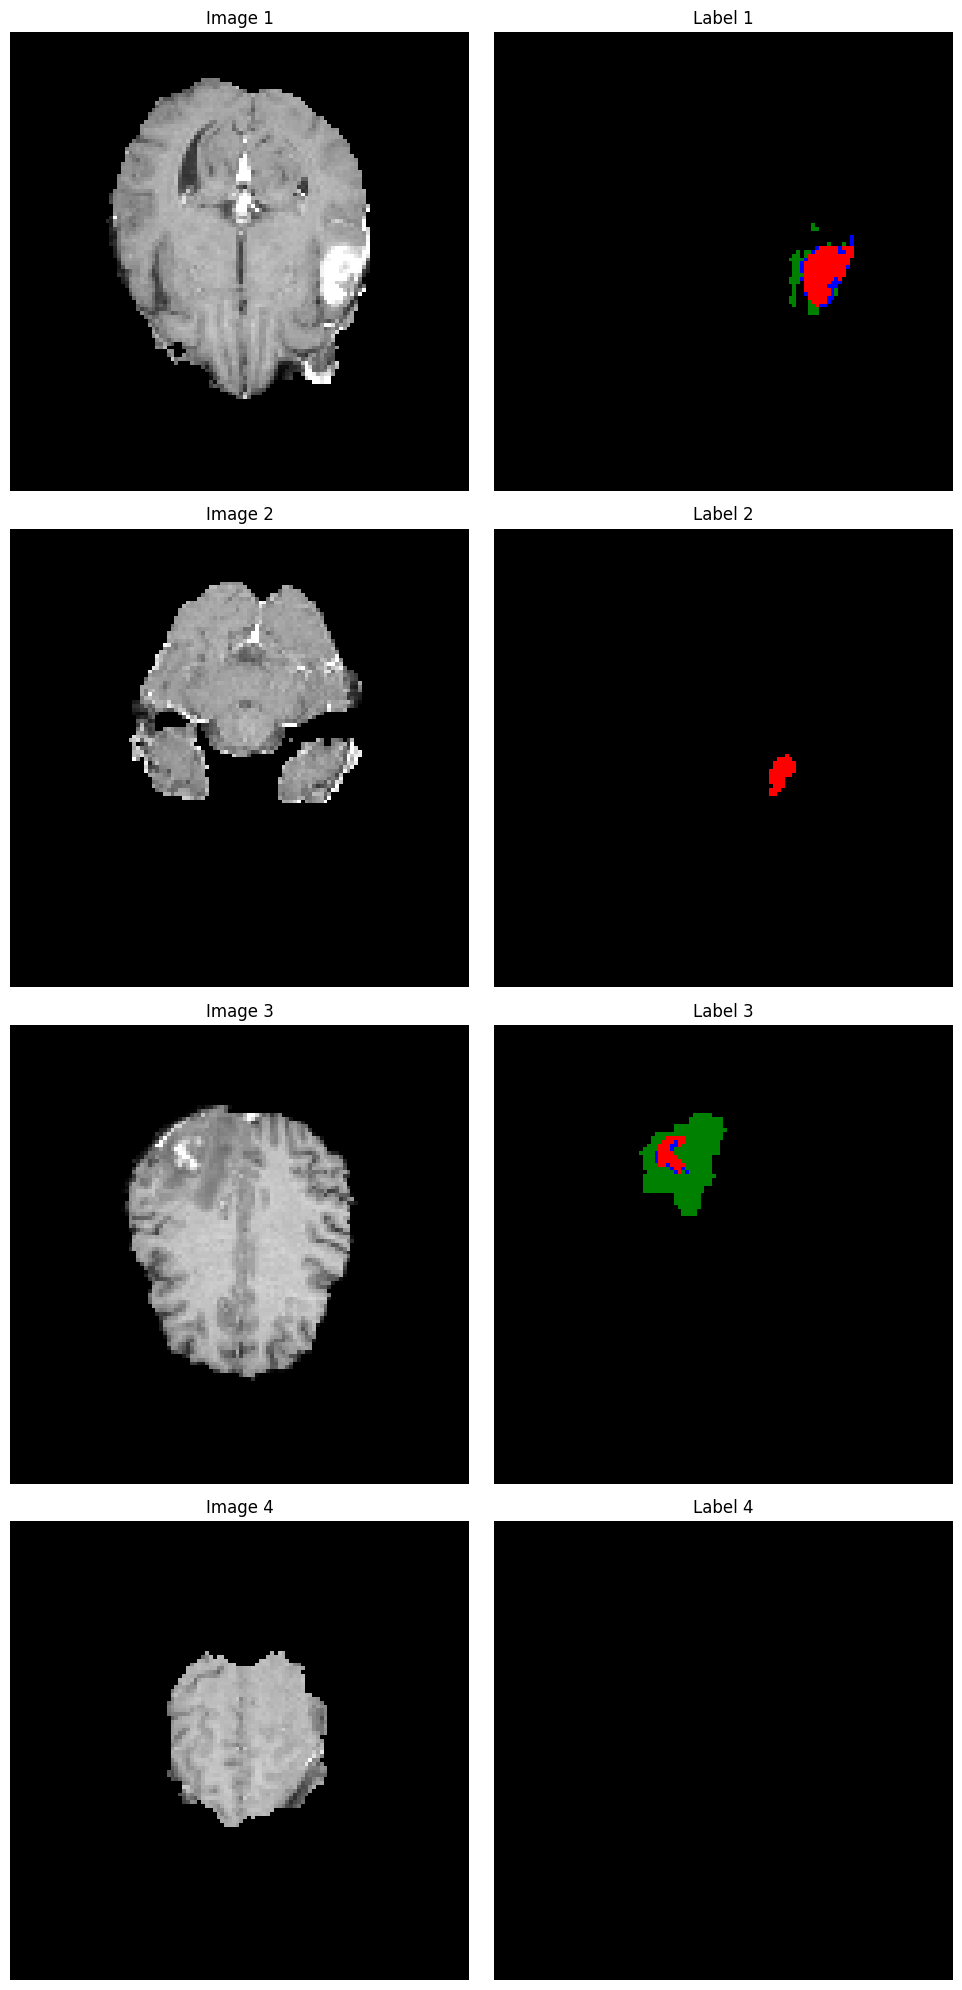

In [24]:
### Insert your code ###
# Define dataset directories
image_dir = 'Task01_BrainTumour_2D/training_images/'
label_dir = 'Task01_BrainTumour_2D/training_labels/'

# Get the list of image and label files
image_files = os.listdir(image_dir)
label_files = os.listdir(label_dir)

# Randomly select 4 images
selected_files = random.sample(image_files, 4)

# Define color maps
cmap_gray = 'gray'  # Grayscale for MRI images
cmap_segmentation = colors.ListedColormap(['black', 'green', 'blue', 'red'])  # Color map for segmentation labels

# Create a 4x2 subplot
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

for i, file_name in enumerate(selected_files):
    # Load the MRI image
    image = imageio.imread(os.path.join(image_dir, file_name))

    # Load the corresponding segmentation label
    label_file = file_name.replace("image", "mask")  # Modify based on dataset file naming
    if label_file not in label_files:
        print(f"Warning: Label file {label_file} not found. Skipping...")
        continue
    label = imageio.imread(os.path.join(label_dir, label_file))

    # Display MRI image
    axes[i, 0].imshow(image, cmap=cmap_gray)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {i+1}')

    # Display segmentation label
    axes[i, 1].imshow(label, cmap=cmap_segmentation)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Label {i+1}')

plt.tight_layout()
plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [12]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []
        batch_indices = random.sample(range(len(self.images)), batch_size)

        for idx in batch_indices:
          image, label = self[idx]

          images.append(image)
          labels.append(label)

        images = np.array(images)
        labels = np.array(labels)

        images = np.expand_dims(images, axis=1)
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [13]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        # Decoder path
        n = num_filter * 8  # 128

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(int(n), int(n / 2), kernel_size=2, stride=2),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU()
        )

        n = int(n / 2)  # 64
        self.conv_decode3 = nn.Sequential(
            nn.Conv2d(int(n * 2), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU(),
            nn.Conv2d(int(n), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(int(n), int(n / 2), kernel_size=2, stride=2),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.conv_decode2 = nn.Sequential(
            nn.Conv2d(int(n * 2), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU(),
            nn.Conv2d(int(n), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(int(n), int(n / 2), kernel_size=2, stride=2),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU()
        )

        n = int(n / 2)  # 16
        self.conv_decode1 = nn.Sequential(
            nn.Conv2d(int(n * 2), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU(),
            nn.Conv2d(int(n), int(n), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n)),
            nn.ReLU()
        )

        # Final output layer
        self.final = nn.Conv2d(int(n), output_channel, kernel_size=1)

        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv3(x)
        x = torch.cat((x, conv3_skip), dim=1)
        x = self.conv_decode3(x)
        x = self.upconv2(x)
        x = torch.cat((x, conv2_skip), dim=1)
        x = self.conv_decode2(x)
        x = self.upconv1(x)
        x = torch.cat((x, conv1_skip), dim=1)
        x = self.conv_decode1(x)
        # Output layer
        x = self.final(x)
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [23]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            test_logits = model(test_images)
            # Compute loss
            test_loss = criterion(test_logits, test_labels)
            print(f'Iteration {it}, Test Loss: {test_loss.item()}')
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iteration 100, Test Loss: 0.2268347144126892
Iteration 200, Test Loss: 0.13187649846076965
Iteration 300, Test Loss: 0.07660418748855591
Iteration 400, Test Loss: 0.08942575007677078
Iteration 500, Test Loss: 0.08120511472225189
Iteration 600, Test Loss: 0.07181122153997421
Iteration 700, Test Loss: 0.06872417777776718
Iteration 800, Test Loss: 0.08545562624931335
Iteration 900, Test Loss: 0.05672481283545494
Iteration 1000, Test Loss: 0.06435705721378326
Iteration 1100, Test Loss: 0.046366021037101746
Iteration 1200, Test Loss: 0.09119458496570587
Iteration 1300, Test Loss: 0.031208744272589684
Iteration 1400, Test Loss: 0.06280447542667389
Iteration 1500, Test Loss: 0.061374686658382416
Iteration 1600, Test Loss: 0.03593908250331879
Iteration 1700, Test Loss: 0.05854962393641472
Iteration 1800, Test Loss: 0.04893062636256218
Iteration 1900, Test Loss: 0.035530488938093185
Iteration 2000, Test Loss: 0.0647897720336914
Iteration 2100, Test Loss: 0.029925663024187088
Iterat

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

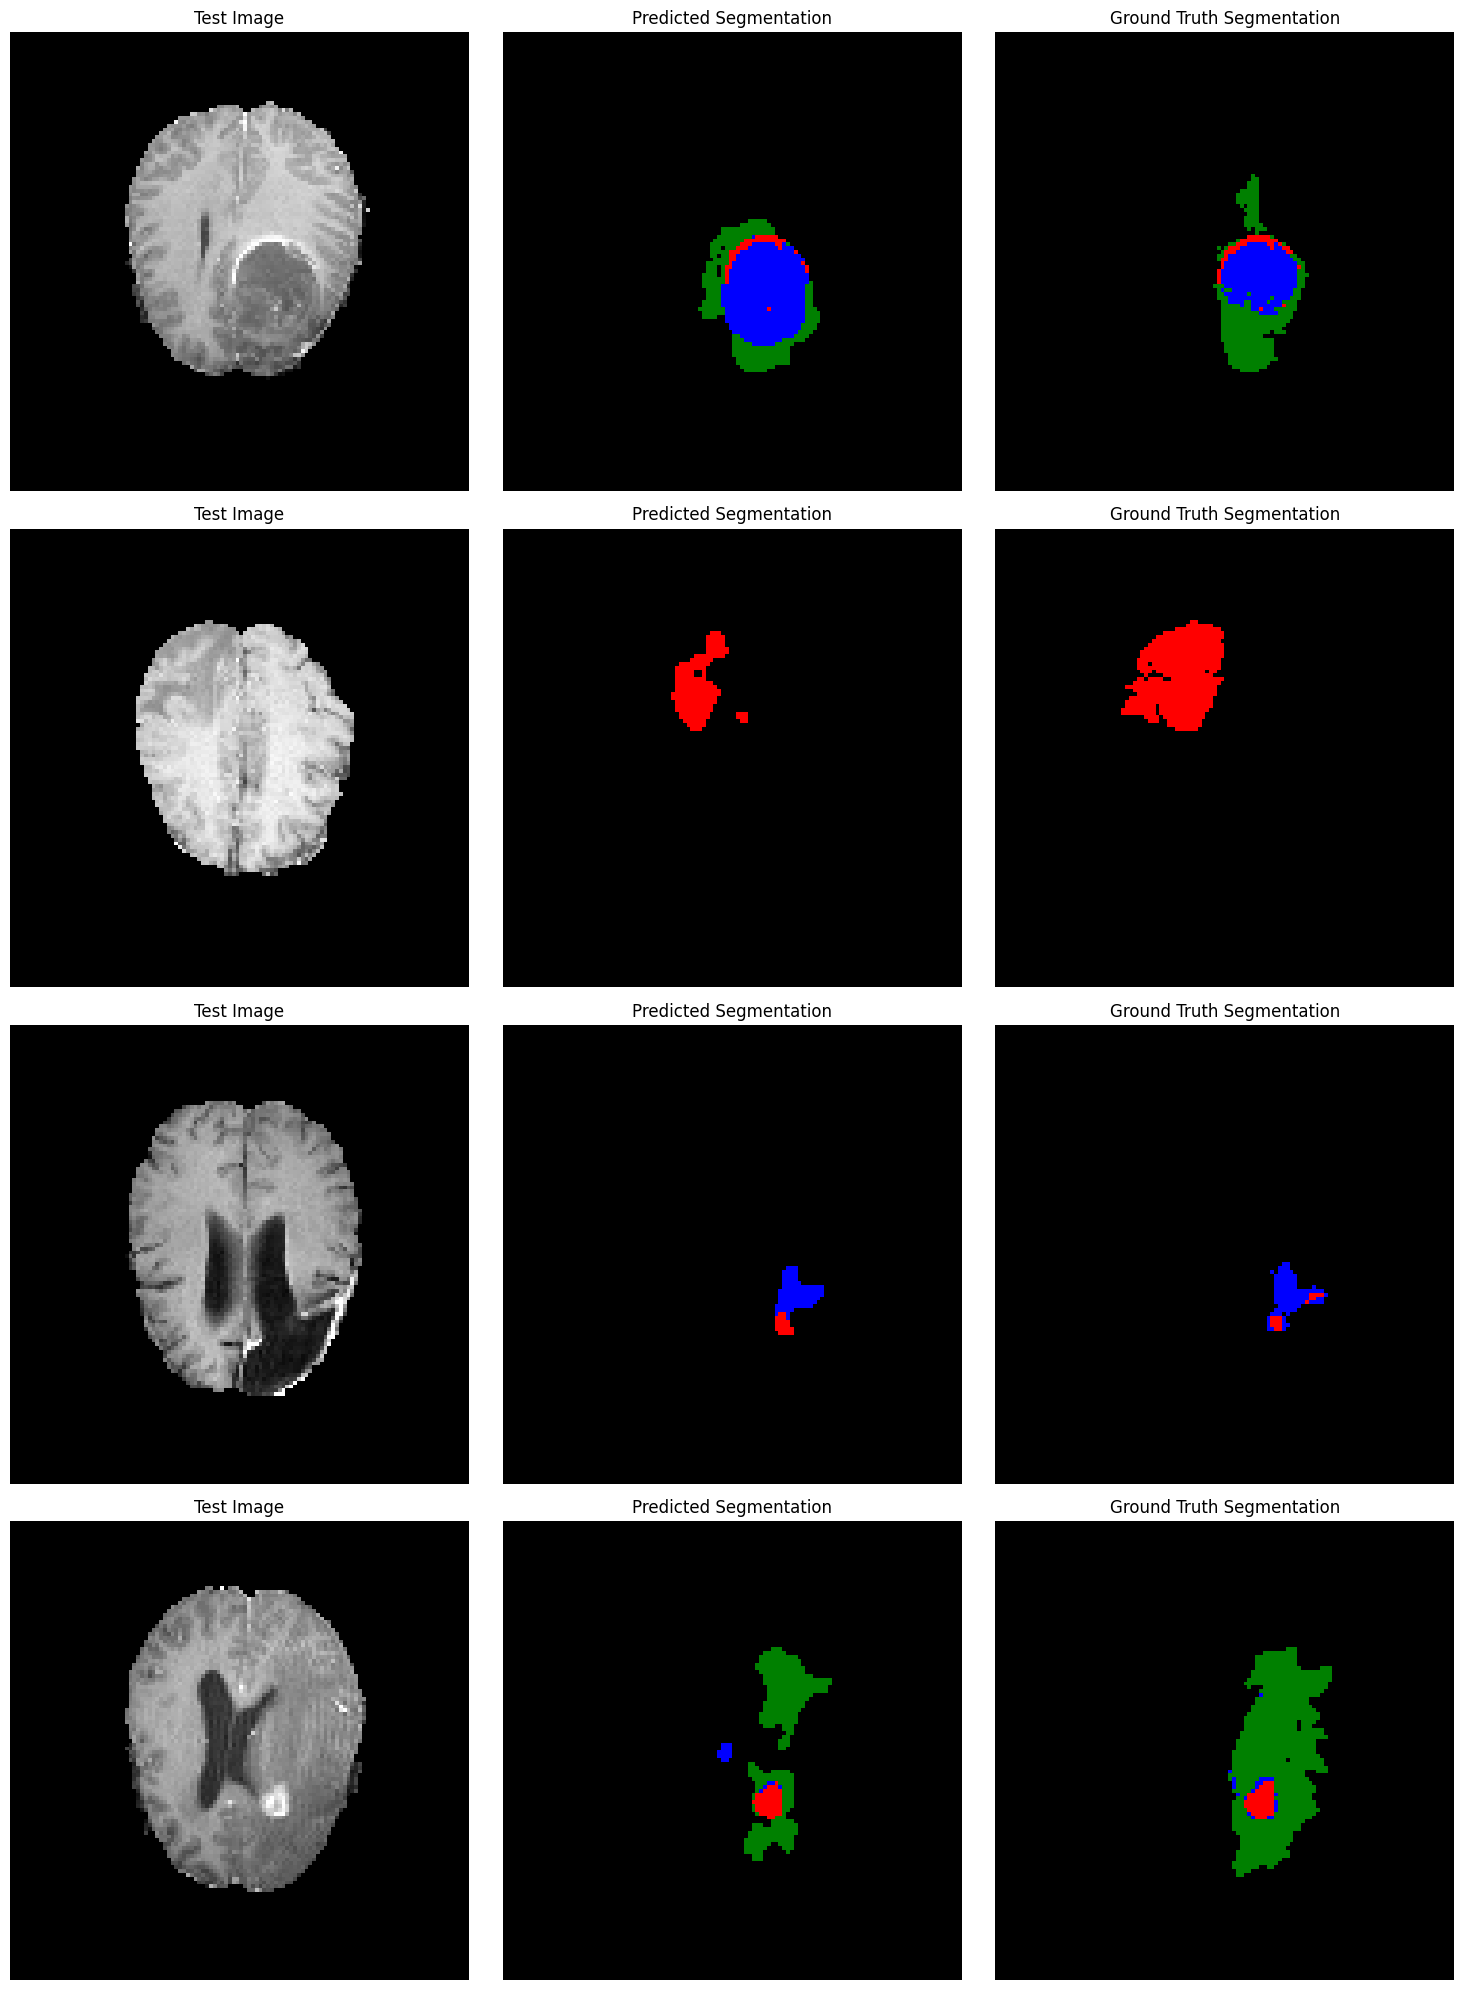

In [26]:
### Insert your code ###
# Set model to evaluation mode
model.eval()

# Get a batch of test images
test_images, test_labels = test_set.get_random_batch(4)
test_images_tensor = torch.from_numpy(test_images).to(device, dtype=torch.float32)

# Run inference
with torch.no_grad():
    predicted_logits = model(test_images_tensor)
    predicted_labels = torch.argmax(predicted_logits, dim=1).cpu().numpy()

# Visualization
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

for i in range(4):
    # Original MRI image
    axes[i, 0].imshow(test_images[i, 0], cmap='gray')
    axes[i, 0].set_title('Test Image')
    axes[i, 0].axis('off')

    # Model prediction
    axes[i, 1].imshow(predicted_labels[i], cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axes[i, 1].set_title('Predicted Segmentation')
    axes[i, 1].axis('off')

    # Ground truth
    axes[i, 2].imshow(test_labels[i], cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axes[i, 2].set_title('Ground Truth Segmentation')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

# Model Evaluation
The figure in Task 5 shows that the trained U-Net model closely aligns with the ground truth, successfully distinguishing between the background, edema, non-enhancing, and enhancing tumors. The training loss converges towards the end, although occasional fluctuations suggest room for further fine-tuning. However, some segmentation errors remain, with certain regions either over-classified or under-classified.

In Task 4, running inference on a CPU takes nearly an hour until a GPU is used, highlighting inefficiencies that make real-time deployment impractical.


# Model Improvement
To make the model more robust and efficient, a few improvements could be made. Adding more **data augmentation**—such as rotation, flipping, and scaling—can help the model generalize better to unseen data. Trying **more advanced architectures**, like UNet++ or DeepLabv3+, might improve segmentation accuracy by capturing both local and global image features more effectively. **Hyperparameter tuning**, such as adjusting batch size, learning rate, and the number of filters, could further refine the model’s performance. Exploring **alternative loss functions** like Dice Loss or Jaccard Loss might also help the model focus more on boundary regions, reducing segmentation errors. Lastly, switching to **GPU acceleration** and optimizing the batch processing pipeline could significantly reduce inference time.